In [1]:
from bs4 import BeautifulSoup
import requests
import os
import re
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Generate a list with all seasons to extract, since 1996
year_seasons = [x for x in range(1996, 2024)]

# Getting the html file for all seasons
for year in year_seasons:
  filename = 'advanced_' + str(year) + '.html'
  url = f'https://www.basketball-reference.com/leagues/NBA_{year}.html'
  page = requests.get(url).text

  # Saving the html files locally so we don't have to send any more requests
  with open(filename, 'w') as f:
    f.write(page)

In [4]:
# Empty list that will contain the dataframes for each year
all_years = []

# Iterating over all html files
for f in os.listdir('/content'):
  if f.endswith('.html'):
    with open(f, 'r') as html_file:
      html_advanced = BeautifulSoup(html_file, 'lxml')

      # Findind the advanced table
      table = html_advanced.find('table', id='advanced-team')
      headers = table.find_all('th', class_=lambda x: x != 'over_header')

      # Getting the column names
      col_names = []

      for h in headers[5:-34]:
        text = h.text
        real_col_name = re.search('[\d\w]+', text)
        if real_col_name != None:
          col_names.append(text)

      col_names.remove('Rk')

      # List that will contain all rows of data
      data_rows = []

      all_rows = table.find_all('tr')

      # Extracting the data
      for r in all_rows:
        all_cells = r.find_all('td')
        row = []
        for c in all_cells[:-3]:
          real_data = re.search('[\d\w]+', c.text)
          if real_data != None:
            row.append(c.text)
        
        data_rows.append(row)

        # Creating a dataframe from the previous list
        final_df = pd.DataFrame(data_rows[2:-1], columns=col_names)
        # Adding the year as a new column (extracted from the file name)
        final_df['year'] = int(f[-9:-5])
      
      # Appending the dataframe to the initial list that we created
      all_years.append(final_df)


In [5]:
# Now we can concatenate all dataframes to get a single one
all_years_df = pd.concat(all_years).reset_index(drop=True)

all_years_df.head()

Team   Age   W   L  PW  PL    MOV    SOS    SRS   ORtg  \
0  Golden State Warriors*  28.2  67  15  67  15  11.63  -0.28  11.35  115.6   
1      San Antonio Spurs*  29.6  61  21  60  22   7.20  -0.06   7.13  111.1   
2        Houston Rockets*  27.4  55  27  55  27   5.77   0.08   5.84  114.7   
3        Toronto Raptors*  26.1  51  31  52  30   4.21  -0.56   3.65  112.3   
4   Los Angeles Clippers*  30.0  51  31  52  30   4.29   0.13   4.42  112.7   

    DRtg   NRtg   Pace   FTr  3PAr   TS%  eFG%  TOV%  ORB% FT/FGA  eFG%  TOV%  \
0  104.0  +11.6   99.8  .259  .359  .597  .563  13.2  22.8   .204  .486  13.5   
1  103.5   +7.6   94.2  .263  .281  .564  .524  12.6  24.0   .210  .492  13.5   
2  109.0   +5.7  100.0  .304  .462  .583  .545  13.3  24.6   .233  .519  13.2   
3  107.8   +4.5   94.7  .293  .289  .561  .517  11.8  25.0   .233  .507  13.5   
4  108.2   +4.5   96.1  .312  .329  .574  .537  12.0  21.5   .233  .506  12.1   

   DRB% FT/FGA  year  
0  74.9   .198  2017  
1  77.6   .192  2017  
2  75.8   .194  2017  
3  76.3   .223  2017  
4  76.9   .211  2017

In [6]:
# Renaming columns as necessary
for i in range(16, 24):
  old_name = all_years_df.columns[i]
  if i < 20:
    new_name = 'off_' + old_name
  else:
    new_name = 'def_' + old_name
    
  all_years_df.columns.values[i] = new_name
  

all_years_df.head()

Team   Age   W   L  PW  PL    MOV    SOS    SRS   ORtg  \
0  Golden State Warriors*  28.2  67  15  67  15  11.63  -0.28  11.35  115.6   
1      San Antonio Spurs*  29.6  61  21  60  22   7.20  -0.06   7.13  111.1   
2        Houston Rockets*  27.4  55  27  55  27   5.77   0.08   5.84  114.7   
3        Toronto Raptors*  26.1  51  31  52  30   4.21  -0.56   3.65  112.3   
4   Los Angeles Clippers*  30.0  51  31  52  30   4.29   0.13   4.42  112.7   

    DRtg   NRtg   Pace   FTr  3PAr   TS% off_eFG% off_TOV% off_ORB%  \
0  104.0  +11.6   99.8  .259  .359  .597     .563     13.2     22.8   
1  103.5   +7.6   94.2  .263  .281  .564     .524     12.6     24.0   
2  109.0   +5.7  100.0  .304  .462  .583     .545     13.3     24.6   
3  107.8   +4.5   94.7  .293  .289  .561     .517     11.8     25.0   
4  108.2   +4.5   96.1  .312  .329  .574     .537     12.0     21.5   

  off_FT/FGA def_eFG% def_TOV% def_DRB% def_FT/FGA  year  
0       .204     .486     13.5     74.9       .198  2017  
1       .210     .492     13.5     77.6       .192  2017  
2       .233     .519     13.2     75.8       .194  2017  
3       .233     .507     13.5     76.3       .223  2017  
4       .233     .506     12.1     76.9       .211  2017

In [7]:
# Replacing all '*' symbols in team names
all_years_df['Team'] = all_years_df['Team'].apply(lambda x: x.replace('*', ''))

all_years_df['Team'].unique()

array(['Golden State Warriors', 'San Antonio Spurs', 'Houston Rockets',
       'Toronto Raptors', 'Los Angeles Clippers', 'Utah Jazz',
       'Cleveland Cavaliers', 'Boston Celtics', 'Washington Wizards',
       'Miami Heat', 'Oklahoma City Thunder', 'Memphis Grizzlies',
       'Denver Nuggets', 'Chicago Bulls', 'Charlotte Hornets',
       'Indiana Pacers', 'Milwaukee Bucks', 'Portland Trail Blazers',
       'Atlanta Hawks', 'Detroit Pistons', 'Minnesota Timberwolves',
       'New Orleans Pelicans', 'Dallas Mavericks', 'New York Knicks',
       'Sacramento Kings', 'Phoenix Suns', 'Philadelphia 76ers',
       'Brooklyn Nets', 'Orlando Magic', 'Los Angeles Lakers',
       'Seattle SuperSonics', 'New Jersey Nets', 'Vancouver Grizzlies',
       'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Washington Bullets'],
      dtype=object)

In [8]:
# Modifying team names, as certain franchises have been called differently
# over the years. This will make analysis easier later
names_change = {'Charlotte Bobcats': 'Charlotte Hornets',
                'Seattle SuperSonics': 'Oklahoma City Thunder',
                'New Jersey Nets': 'Brooklyn Nets',
                'Vancouver Grizzlies': 'Memphis Grizzlies',
                'Washington Bullets': 'Washington Wizards',
                'New Orleans Hornets': 'New Orleans Pelicans',
                'New Orleans/Oklahoma City Hornets': 'New Orleans Pelicans'}

for key, value in names_change.items():
  all_years_df.loc[all_years_df.Team == key, 'Team'] = value

In [9]:
# Checking that the changes have been applied correctly
for team_name in all_years_df['Team'].unique():
  print(team_name)

Golden State Warriors
San Antonio Spurs
Houston Rockets
Toronto Raptors
Los Angeles Clippers
Utah Jazz
Cleveland Cavaliers
Boston Celtics
Washington Wizards
Miami Heat
Oklahoma City Thunder
Memphis Grizzlies
Denver Nuggets
Chicago Bulls
Charlotte Hornets
Indiana Pacers
Milwaukee Bucks
Portland Trail Blazers
Atlanta Hawks
Detroit Pistons
Minnesota Timberwolves
New Orleans Pelicans
Dallas Mavericks
New York Knicks
Sacramento Kings
Phoenix Suns
Philadelphia 76ers
Brooklyn Nets
Orlando Magic
Los Angeles Lakers


In [10]:
all_years_df.shape

(831, 25)

In [11]:
# Making sure that there are no nulls
all_years_df.isnull().sum()

Team          0
Age           0
W             0
L             0
PW            0
PL            0
MOV           0
SOS           0
SRS           0
ORtg          0
DRtg          0
NRtg          0
Pace          0
FTr           0
3PAr          0
TS%           0
off_eFG%      0
off_TOV%      0
off_ORB%      0
off_FT/FGA    0
def_eFG%      0
def_TOV%      0
def_DRB%      0
def_FT/FGA    0
year          0
dtype: int64

In [12]:
all_years_df.apply(lambda x: x == '').sum()

Team          0
Age           0
W             0
L             0
PW            0
PL            0
MOV           0
SOS           0
SRS           0
ORtg          0
DRtg          0
NRtg          0
Pace          0
FTr           0
3PAr          0
TS%           0
off_eFG%      0
off_TOV%      0
off_ORB%      0
off_FT/FGA    0
def_eFG%      0
def_TOV%      0
def_DRB%      0
def_FT/FGA    0
year          0
dtype: int64

In [13]:
# Checking data types
all_years_df.dtypes

Team          object
Age           object
W             object
L             object
PW            object
PL            object
MOV           object
SOS           object
SRS           object
ORtg          object
DRtg          object
NRtg          object
Pace          object
FTr           object
3PAr          object
TS%           object
off_eFG%      object
off_TOV%      object
off_ORB%      object
off_FT/FGA    object
def_eFG%      object
def_TOV%      object
def_DRB%      object
def_FT/FGA    object
year           int64
dtype: object

In [14]:
# Most columns should be numeric
num_cols = all_years_df.columns != 'Team'

all_years_df.loc[:, num_cols] = all_years_df.loc[:, num_cols].apply(pd.to_numeric)

In [15]:
# Making sure that changes have been applied correctly
all_years_df.dtypes

Team           object
Age           float64
W               int64
L               int64
PW              int64
PL              int64
MOV           float64
SOS           float64
SRS           float64
ORtg          float64
DRtg          float64
NRtg          float64
Pace          float64
FTr           float64
3PAr          float64
TS%           float64
off_eFG%      float64
off_TOV%      float64
off_ORB%      float64
off_FT/FGA    float64
def_eFG%      float64
def_TOV%      float64
def_DRB%      float64
def_FT/FGA    float64
year            int64
dtype: object

In [16]:
all_years_df.isnull().sum()

Team          0
Age           0
W             0
L             0
PW            0
PL            0
MOV           0
SOS           0
SRS           0
ORtg          0
DRtg          0
NRtg          0
Pace          0
FTr           0
3PAr          0
TS%           0
off_eFG%      0
off_TOV%      0
off_ORB%      0
off_FT/FGA    0
def_eFG%      0
def_TOV%      0
def_DRB%      0
def_FT/FGA    0
year          0
dtype: int64

In [17]:
all_years_df.head()

Team   Age   W   L  PW  PL    MOV   SOS    SRS   ORtg  \
0  Golden State Warriors  28.2  67  15  67  15  11.63 -0.28  11.35  115.6   
1      San Antonio Spurs  29.6  61  21  60  22   7.20 -0.06   7.13  111.1   
2        Houston Rockets  27.4  55  27  55  27   5.77  0.08   5.84  114.7   
3        Toronto Raptors  26.1  51  31  52  30   4.21 -0.56   3.65  112.3   
4   Los Angeles Clippers  30.0  51  31  52  30   4.29  0.13   4.42  112.7   

    DRtg  NRtg   Pace    FTr   3PAr    TS%  off_eFG%  off_TOV%  off_ORB%  \
0  104.0  11.6   99.8  0.259  0.359  0.597     0.563      13.2      22.8   
1  103.5   7.6   94.2  0.263  0.281  0.564     0.524      12.6      24.0   
2  109.0   5.7  100.0  0.304  0.462  0.583     0.545      13.3      24.6   
3  107.8   4.5   94.7  0.293  0.289  0.561     0.517      11.8      25.0   
4  108.2   4.5   96.1  0.312  0.329  0.574     0.537      12.0      21.5   

   off_FT/FGA  def_eFG%  def_TOV%  def_DRB%  def_FT/FGA  year  
0       0.204     0.486      13.5      74.9       0.198  2017  
1       0.210     0.492      13.5      77.6       0.192  2017  
2       0.233     0.519      13.2      75.8       0.194  2017  
3       0.233     0.507      13.5      76.3       0.223  2017  
4       0.233     0.506      12.1      76.9       0.211  2017

In [18]:
# Creating new columns for relative defensive, offensive, and net rating
# (compared to league average for the year/season)
for new_col, col in zip(['rel_ORtg', 'rel_DRtg', 'rel_NRtg'], 
                        ['ORtg', 'DRtg', 'NRtg']):
  all_years_df[new_col] = all_years_df.groupby('year')[col].transform(lambda x: x - x.mean())

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
all_years_df.columns

Index(['Team', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg',
       'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'off_eFG%', 'off_TOV%',
       'off_ORB%', 'off_FT/FGA', 'def_eFG%', 'def_TOV%', 'def_DRB%',
       'def_FT/FGA', 'year', 'rel_ORtg', 'rel_DRtg', 'rel_NRtg'],
      dtype='object')

In [21]:
# Number of years with an above average offense
all_years_df['off_above_avg'] = all_years_df['rel_ORtg'] > 0

# Including only teams with more than 10 seasons
teams_more_10_seasons = all_years_df.groupby('Team').size().loc[lambda x: x >= 10].index.tolist()

filt_df = all_years_df.loc[all_years_df.Team.isin(teams_more_10_seasons), :]

# The plot will be ordered by the number of seasons with an above average
# offense
plot_order = filt_df.groupby('Team')['off_above_avg'].sum().\
             sort_values(ascending=False).index.tolist()

In [22]:
filt_df.head()

Team   Age   W   L  PW  PL    MOV   SOS    SRS   ORtg  \
0  Golden State Warriors  28.2  67  15  67  15  11.63 -0.28  11.35  115.6   
1      San Antonio Spurs  29.6  61  21  60  22   7.20 -0.06   7.13  111.1   
2        Houston Rockets  27.4  55  27  55  27   5.77  0.08   5.84  114.7   
3        Toronto Raptors  26.1  51  31  52  30   4.21 -0.56   3.65  112.3   
4   Los Angeles Clippers  30.0  51  31  52  30   4.29  0.13   4.42  112.7   

    DRtg  NRtg   Pace    FTr   3PAr    TS%  off_eFG%  off_TOV%  off_ORB%  \
0  104.0  11.6   99.8  0.259  0.359  0.597     0.563      13.2      22.8   
1  103.5   7.6   94.2  0.263  0.281  0.564     0.524      12.6      24.0   
2  109.0   5.7  100.0  0.304  0.462  0.583     0.545      13.3      24.6   
3  107.8   4.5   94.7  0.293  0.289  0.561     0.517      11.8      25.0   
4  108.2   4.5   96.1  0.312  0.329  0.574     0.537      12.0      21.5   

   off_FT/FGA  def_eFG%  def_TOV%  def_DRB%  def_FT/FGA  year  rel_ORtg  \
0       0.204     0.486      13.5      74.9       0.198  2017      6.79   
1       0.210     0.492      13.5      77.6       0.192  2017      2.29   
2       0.233     0.519      13.2      75.8       0.194  2017      5.89   
3       0.233     0.507      13.5      76.3       0.223  2017      3.49   
4       0.233     0.506      12.1      76.9       0.211  2017      3.89   

   rel_DRtg  rel_NRtg  off_above_avg  
0     -4.78     11.57           True  
1     -5.28      7.57           True  
2      0.22      5.67           True  
3     -0.98      4.47           True  
4     -0.58      4.47           True

Text(0.5, 0.98, 'Relative Offensive Rating (compared to league average) over the years')

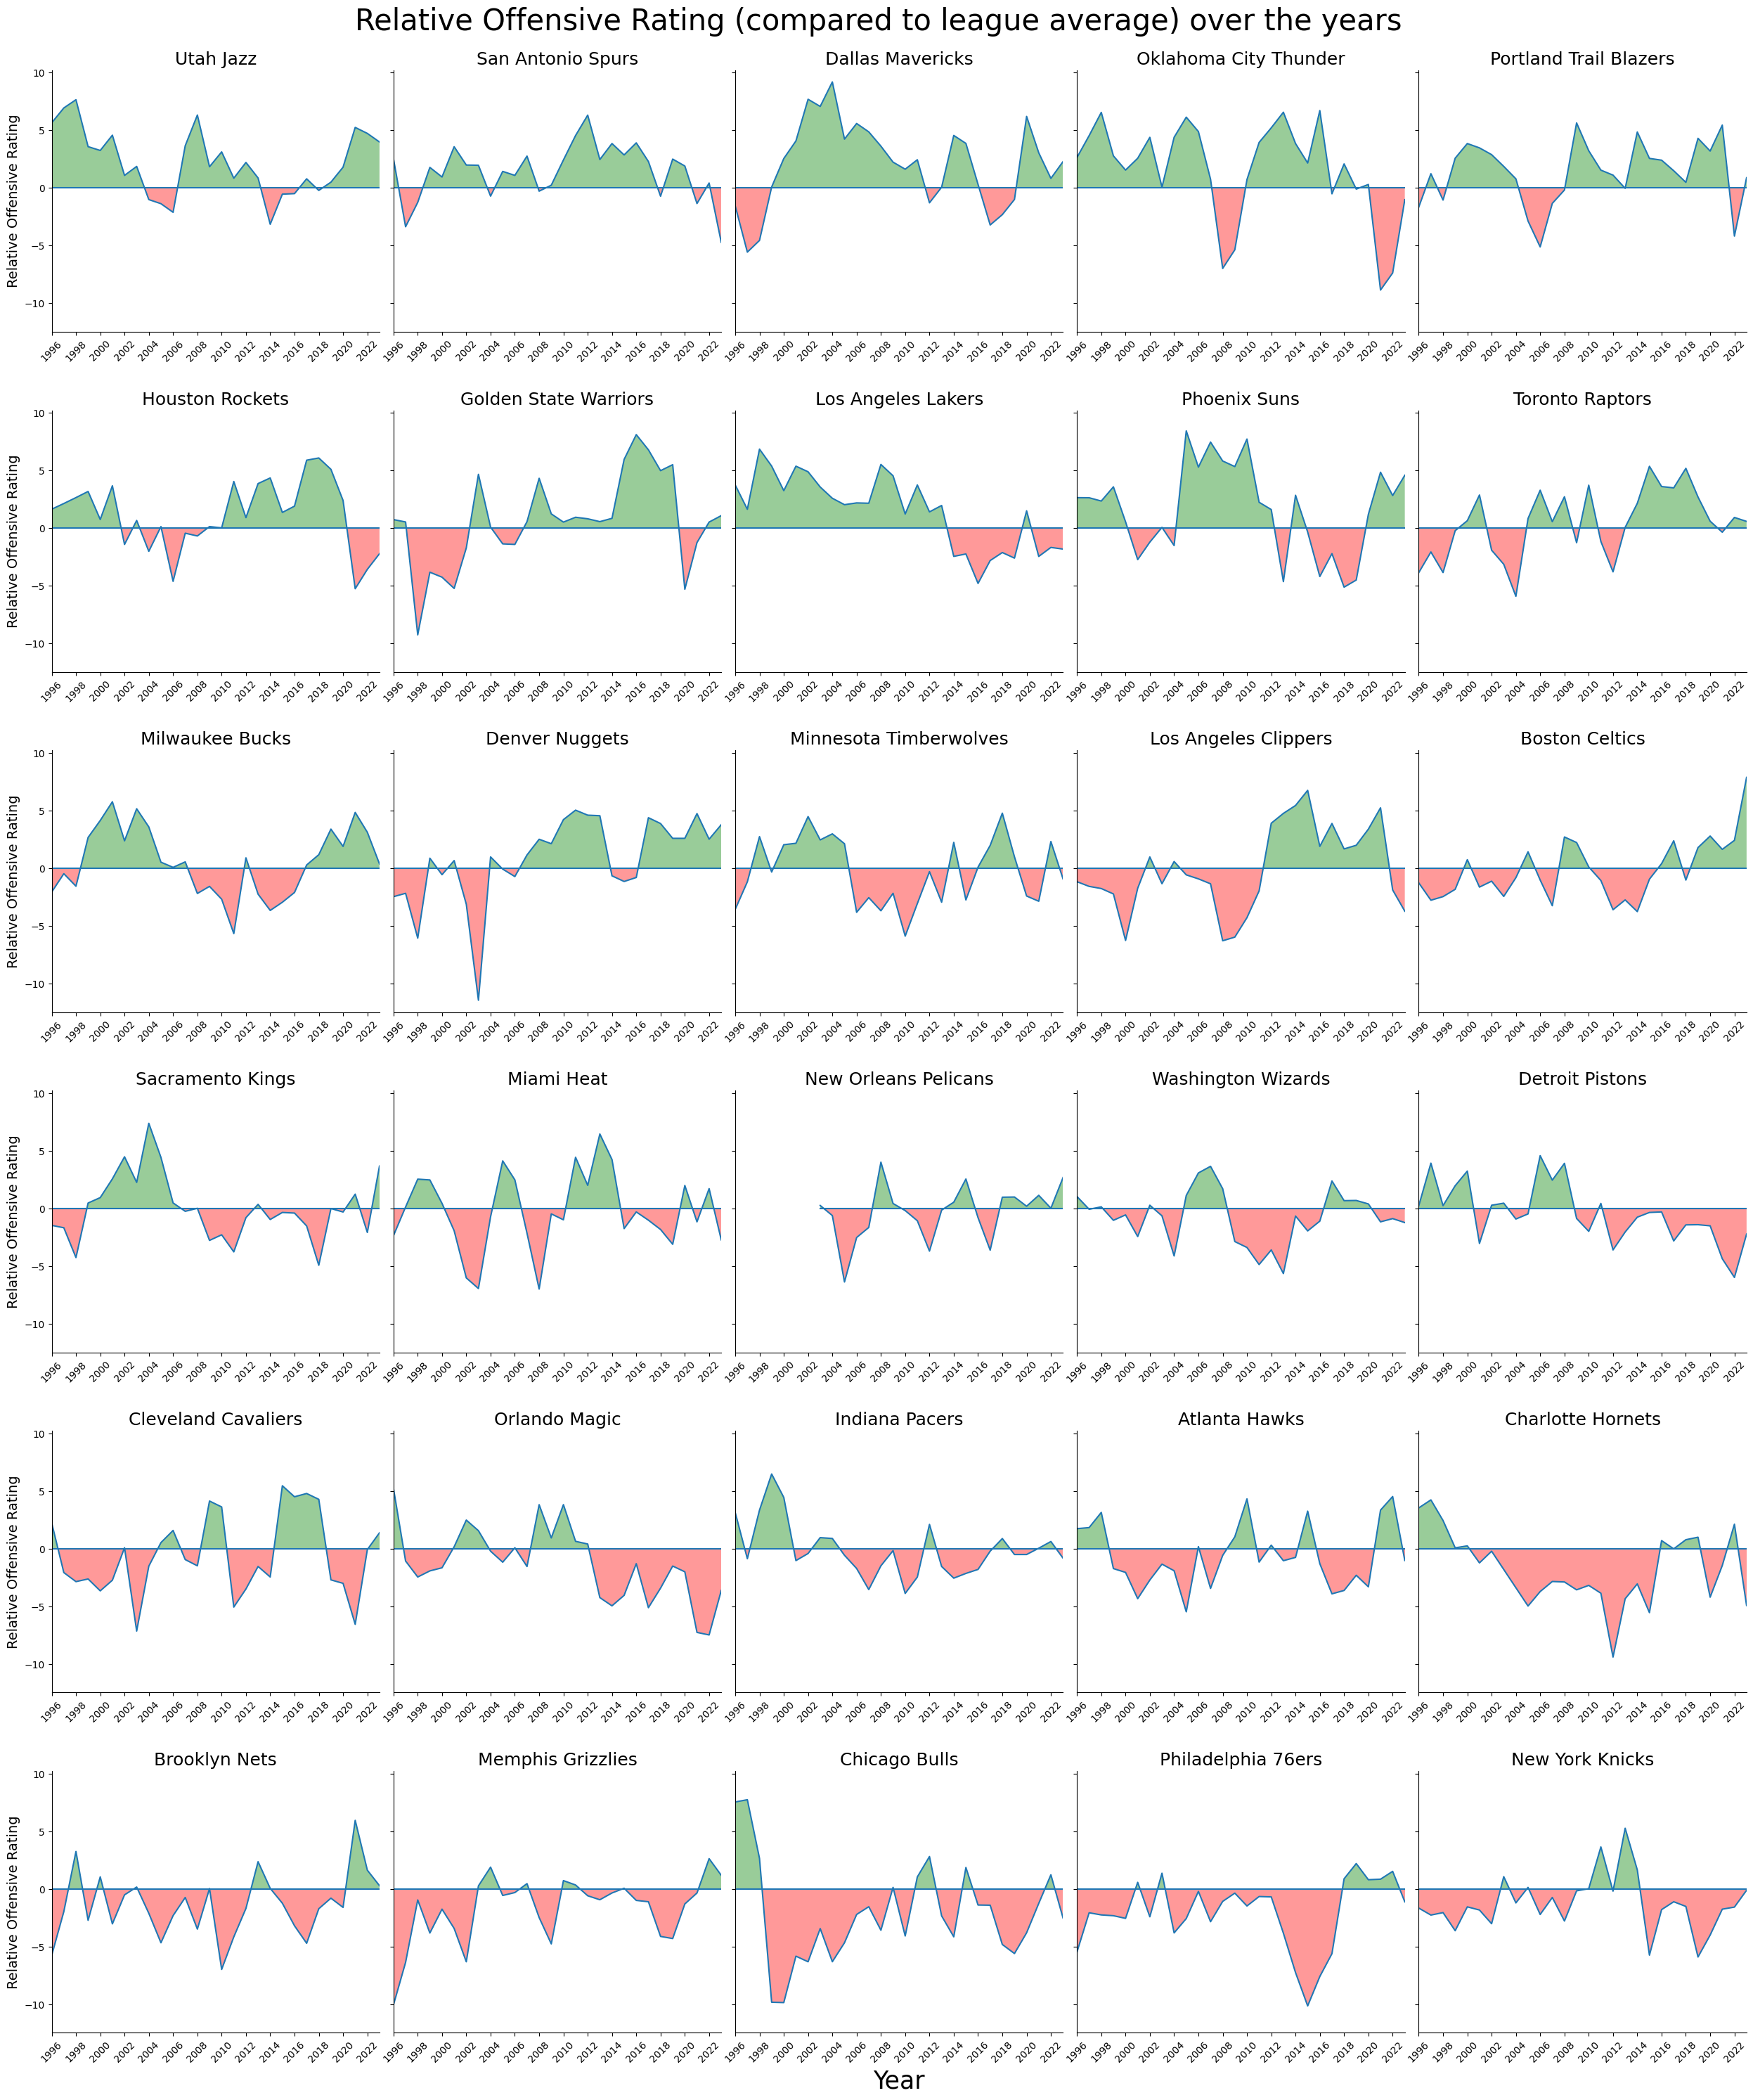

In [23]:
# Creating the FacetGrid so each team has a subplot
plt.style.use('default')
g = sns.FacetGrid(data=filt_df, col='Team', col_wrap=5, height=5,
                  col_order=plot_order, sharex=False, xlim=(1996, 2023))

# Drawing the lineplots
g.map_dataframe(sns.lineplot, x='year', y=0)
g.map_dataframe(sns.lineplot, x='year', y='rel_ORtg')

# https://stackoverflow.com/questions/46248348/seaborn-matplotlib-how-to-access-line-values-in-facetgrid
# Filling between lines; green when a team is above average, red when it is
# below average
for ax in g.axes.flat:
  x = ax.lines[0].get_xdata().astype(int)
  y1 = ax.lines[0].get_ydata(0)
  y2 = ax.lines[1].get_ydata()
  ax.fill_between(x, y1, y2, where=y2 < y1, facecolor='red', 
                  interpolate=True, alpha=0.4)
  ax.fill_between(x, y1, y2, where=y2 > y1, facecolor='green', 
                  interpolate=True, alpha=0.4)

# Xtick marks and xtick labels
xticks = [y for y in all_years_df.year.sort_values().unique().tolist()]
xticks = xticks[::2]
g.set(xticks=xticks)
g.set_xticklabels(labels=[str(y) for y in xticks], rotation=45)
g.fig.subplots_adjust(hspace=0.3)

# Y labels
g.set_ylabels('Relative Offensive Rating', fontsize=14)
g.set_titles(template='{col_name}', size=18)

# X labels
g.set_xlabels('')
g.axes[-3].set_xlabel('Year', fontsize=25, labelpad=5)

# Title
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Relative Offensive Rating (compared to league average) over the years',
               size=30)

In [24]:
# Years with an above average defense (in this case, it means being
# BELOW league average numerically)
all_years_df['def_above_avg'] = all_years_df['rel_DRtg'] < 0

In [25]:
# Number of years with an above average defense
plot_order_def = all_years_df.groupby('Team')['def_above_avg'].sum().\
                 sort_values(ascending=False).index.tolist()

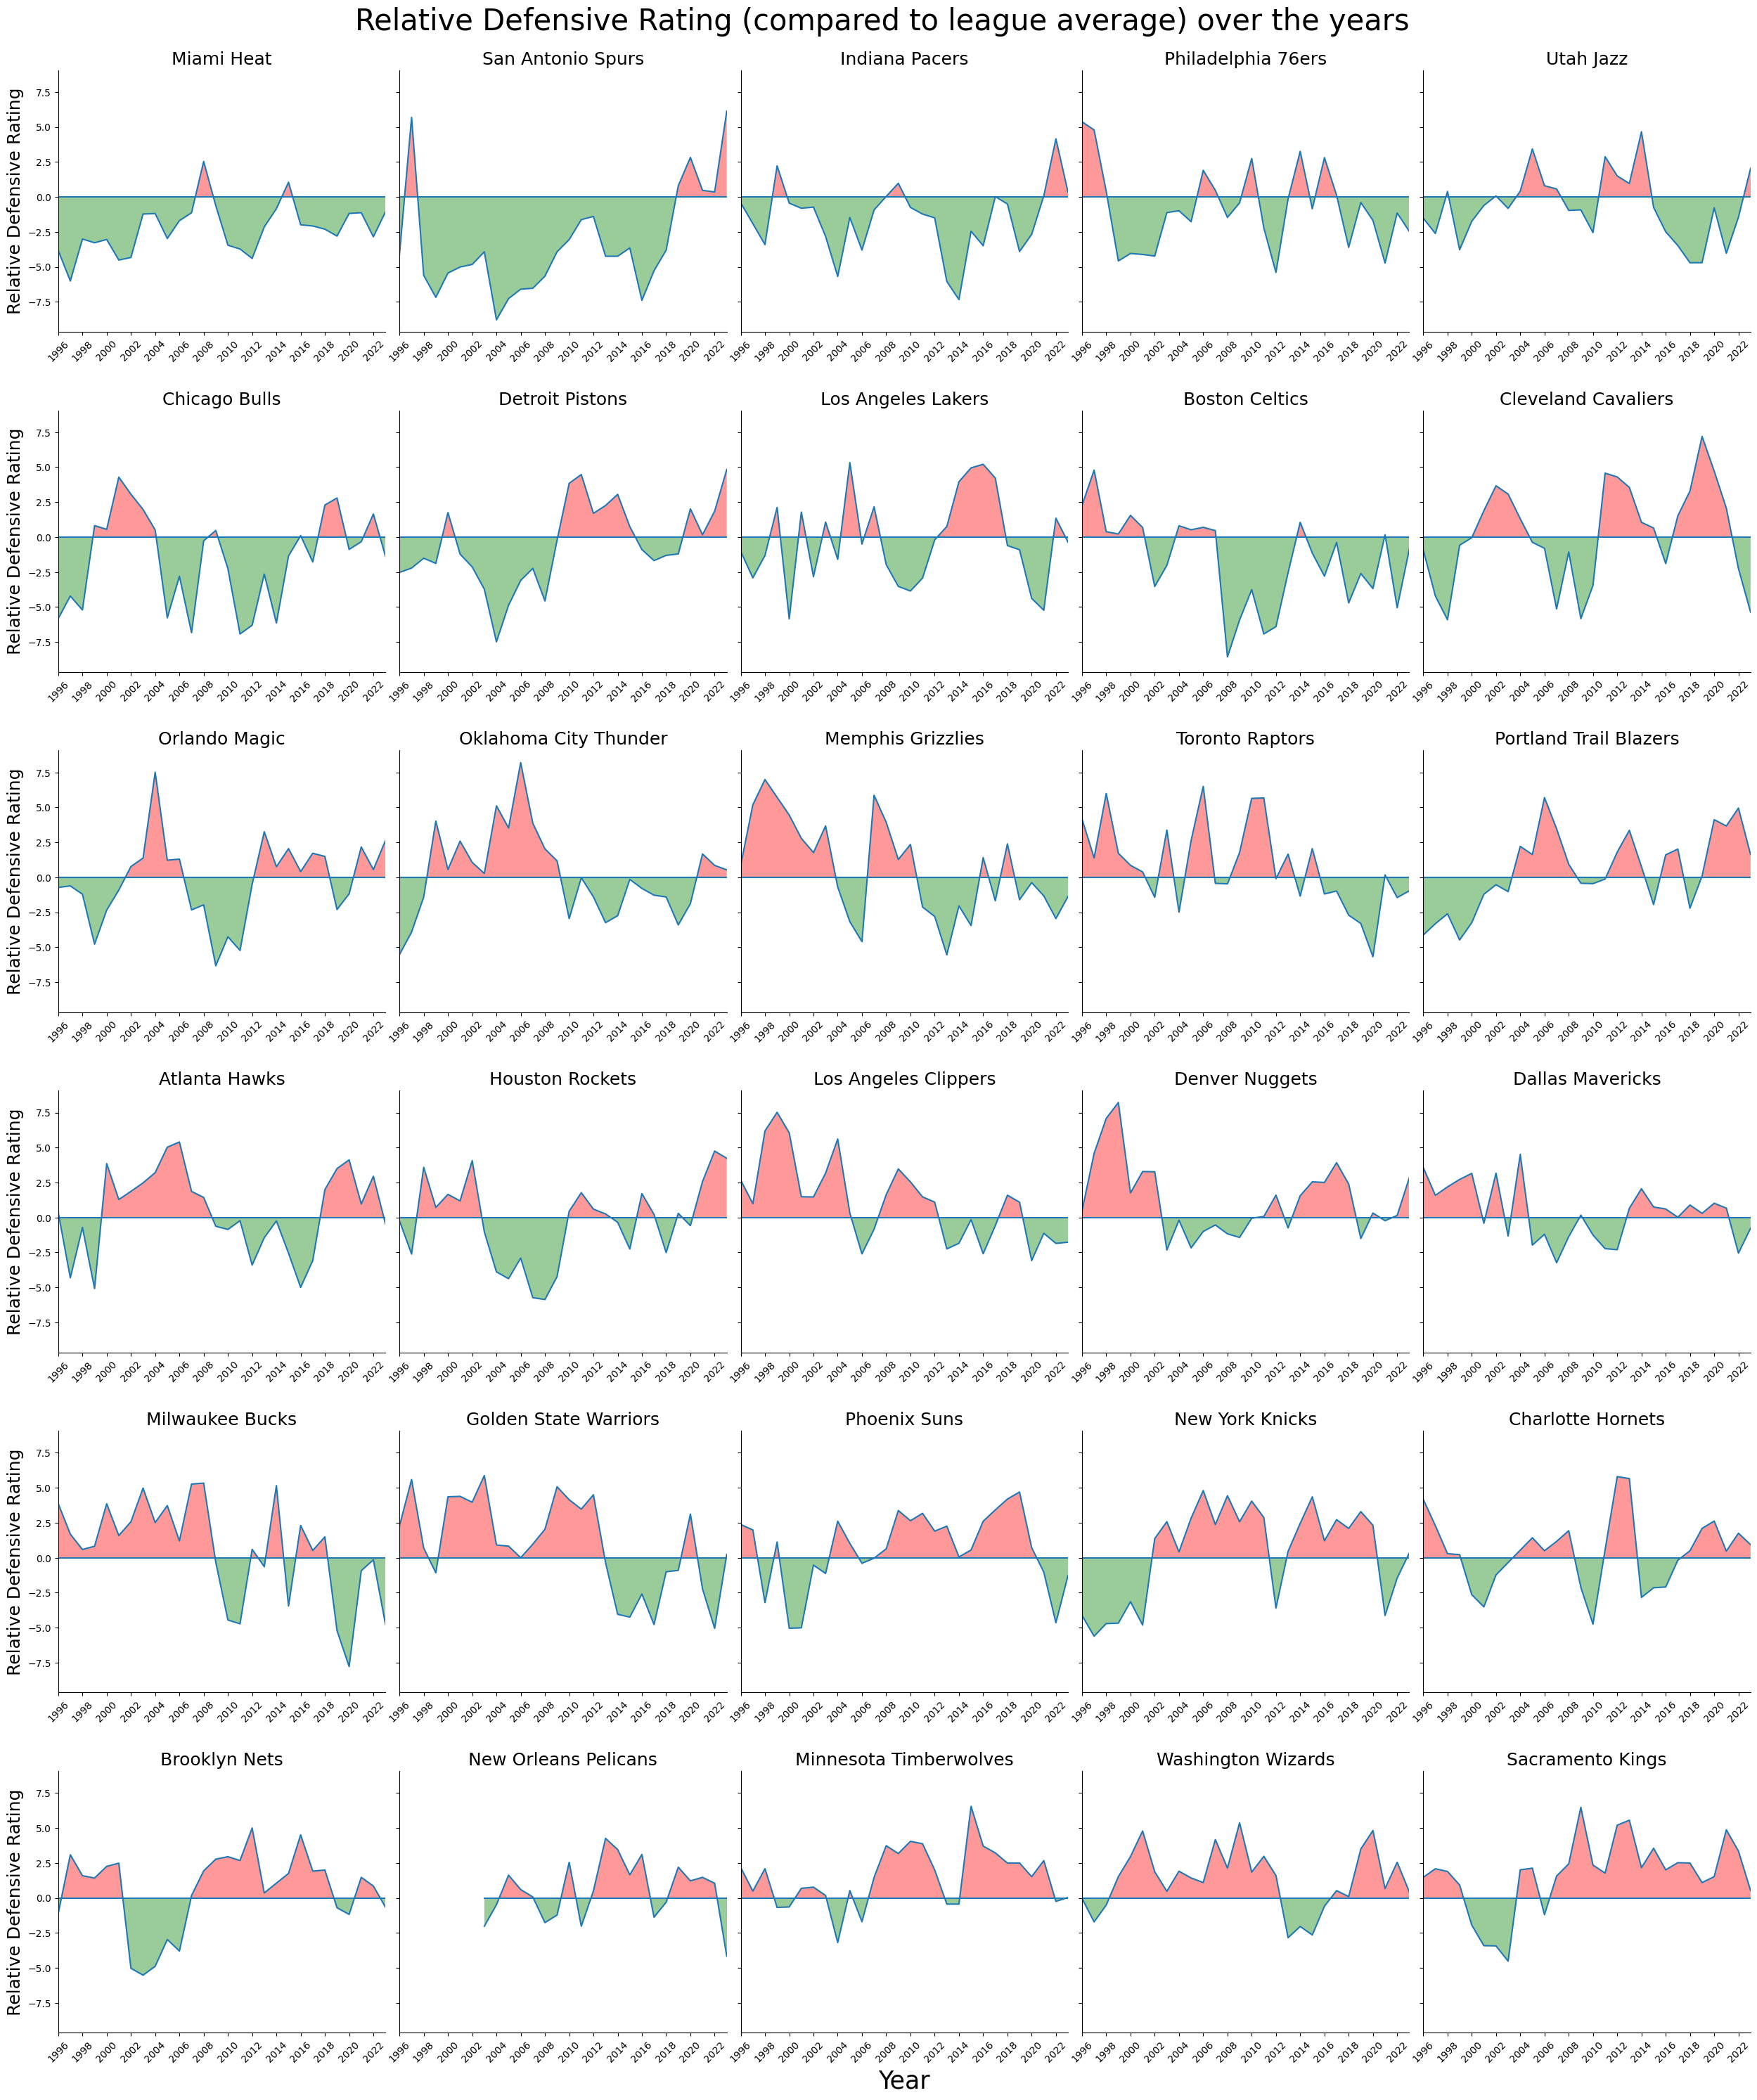

In [26]:
# FacetGrid for all teams
g = sns.FacetGrid(data=filt_df, col='Team', col_wrap=5, height=5,
                  col_order=plot_order_def, sharex=False, xlim=(1996, 2023))

# Drawing the lineplots
g.map_dataframe(sns.lineplot, x='year', y=0)
g.map_dataframe(sns.lineplot, x='year', y='rel_DRtg')

# https://stackoverflow.com/questions/46248348/seaborn-matplotlib-how-to-access-line-values-in-facetgrid
# Filling between curves; red for a below average defense, green for an above
# average defense
for ax in g.axes.flat:
  x = ax.lines[0].get_xdata().astype(int)
  y1 = ax.lines[0].get_ydata(0)
  y2 = ax.lines[1].get_ydata()
  ax.fill_between(x, y1, y2, where=y2 > y1, facecolor='red', 
                  interpolate=True, alpha=0.4)
  ax.fill_between(x, y1, y2, where=y2 < y1, facecolor='green', 
                  interpolate=True, alpha=0.4)

# Setting xticks and xtick labels
xticks = [y for y in all_years_df.year.sort_values().unique().tolist()]
xticks = xticks[::2]
g.set(xticks=xticks)
g.set_xticklabels(labels=[str(y) for y in xticks], rotation=45)
g.fig.subplots_adjust(hspace=0.3)

# Setting y labels
g.set_ylabels('Relative Defensive Rating', fontsize=18)

# Individual titles for subplots
g.set_titles(template='{col_name}', size=18)

# Title
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Relative Defensive Rating (compared to league average) over the years',
               size=30)

# X label
g.set_xlabels('')
g.axes[-3].set_xlabel('Year', fontsize=25, labelpad=5)

plt.savefig('rel_def.png', dpi=300)

In [27]:
# Calculating the percentage of seasons/years with an above average offense
# since 1996
stack_df = all_years_df.groupby('Team')[['off_above_avg']].\
           agg(n_ba=('off_above_avg', lambda x: ((x == 0).sum() / x.count()) * 100),
               n_aa=('off_above_avg', lambda x: (x.sum() / x.count()) * 100 )).reset_index()
           
stack_df.sort_values('n_aa', ascending=True, inplace=True)

(-0.5, 29.5)

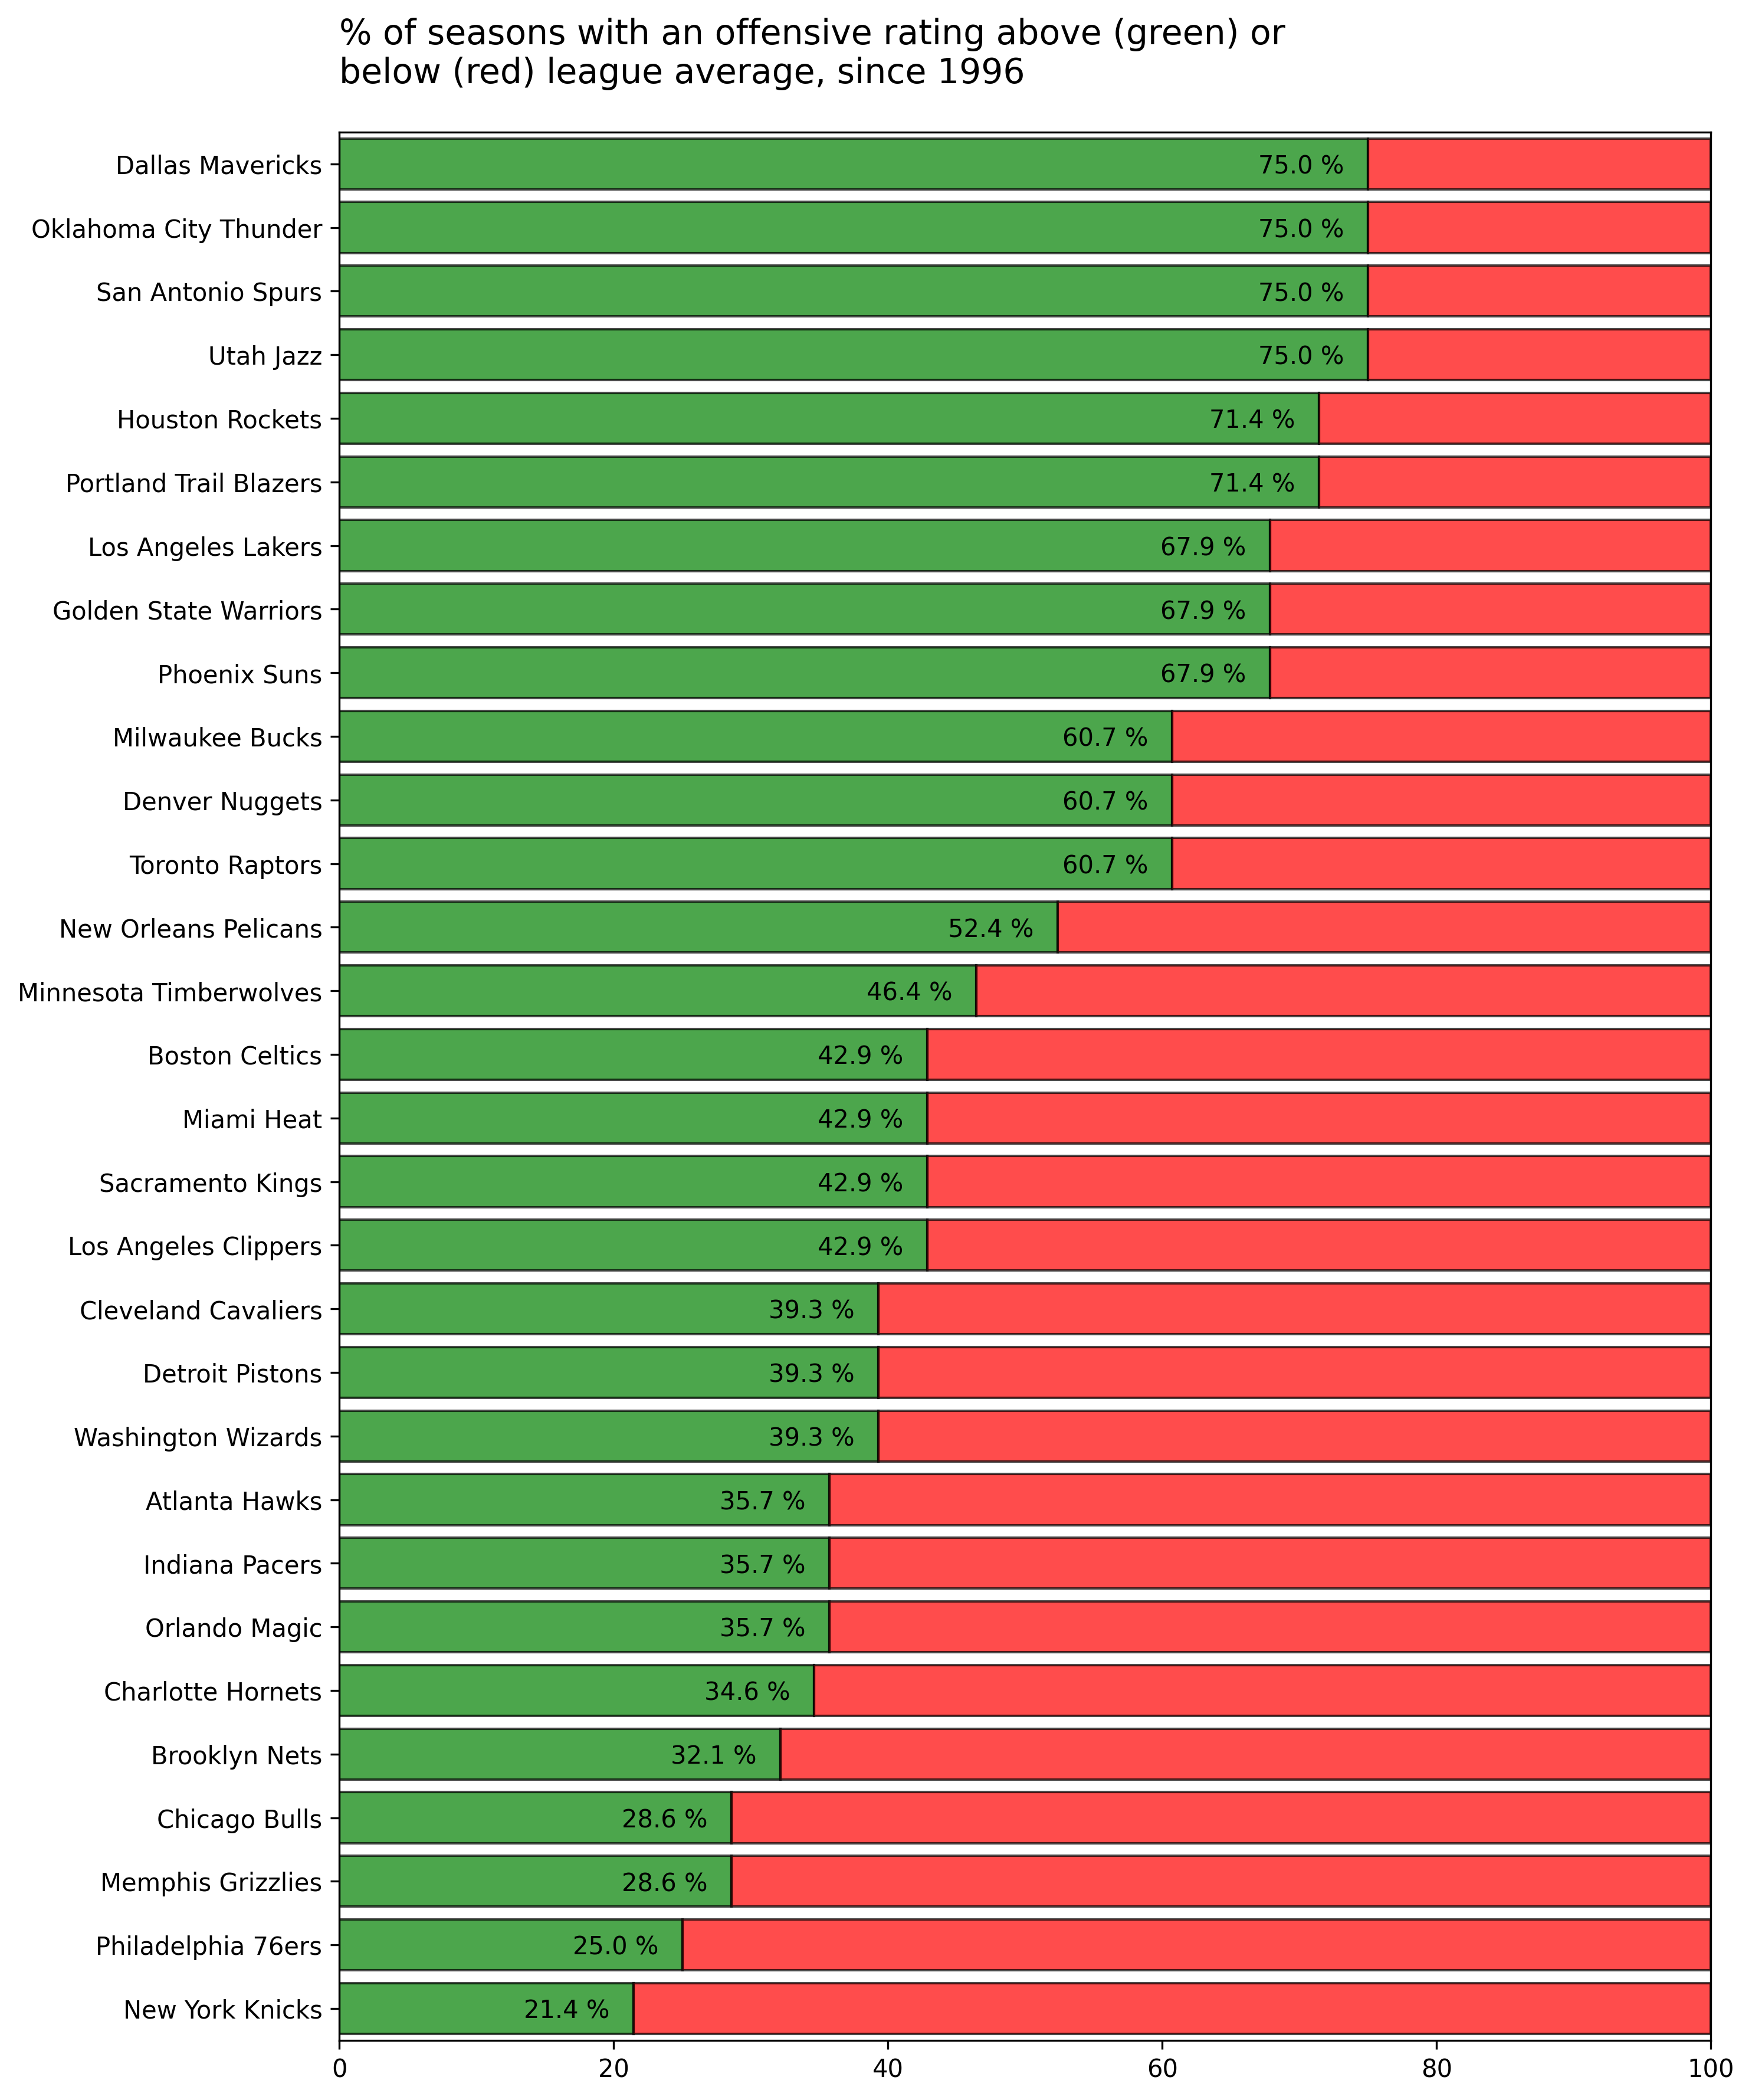

In [28]:
# Setting the figure size
figure, ax = plt.subplots(figsize=(10, 14), dpi=300)

# Plotting the % of winning seasons
ax.barh(y=stack_df.Team, width=stack_df.n_aa, color='green',
        alpha=0.7, height=0.8, edgecolor='black')

# Plotting labels (% of seasons with above average offense)
for i, v in enumerate(stack_df.n_aa):
    ax.text(v - 8, i - 0.15, str(round(v, 1)) + ' %', 
            color='black', fontsize=10)

# Plotting the % of losing seasons
ax.barh(y=stack_df.Team, width=stack_df.n_ba, color='red',
        left=stack_df.n_aa, alpha=0.7, height=0.8,
        edgecolor='black')

# Title
plt.title("% of seasons with an offensive rating above (green) or \nbelow (red) league average, since 1996",
          size=14, loc='left', pad=20)

# Axis limits
plt.xlim(0, 100)
plt.ylim(-0.5, 29.5)

In [29]:
# % of years with an above average defense
stack_df_def = all_years_df.groupby('Team')[['def_above_avg']].\
           agg(n_ba=('def_above_avg', lambda x: ((x == 0).sum() / x.count()) * 100),
               n_aa=('def_above_avg', lambda x: (x.sum() / x.count()) * 100 )).reset_index()
           
stack_df_def.sort_values('n_aa', ascending=True, inplace=True)

(-0.5, 29.5)

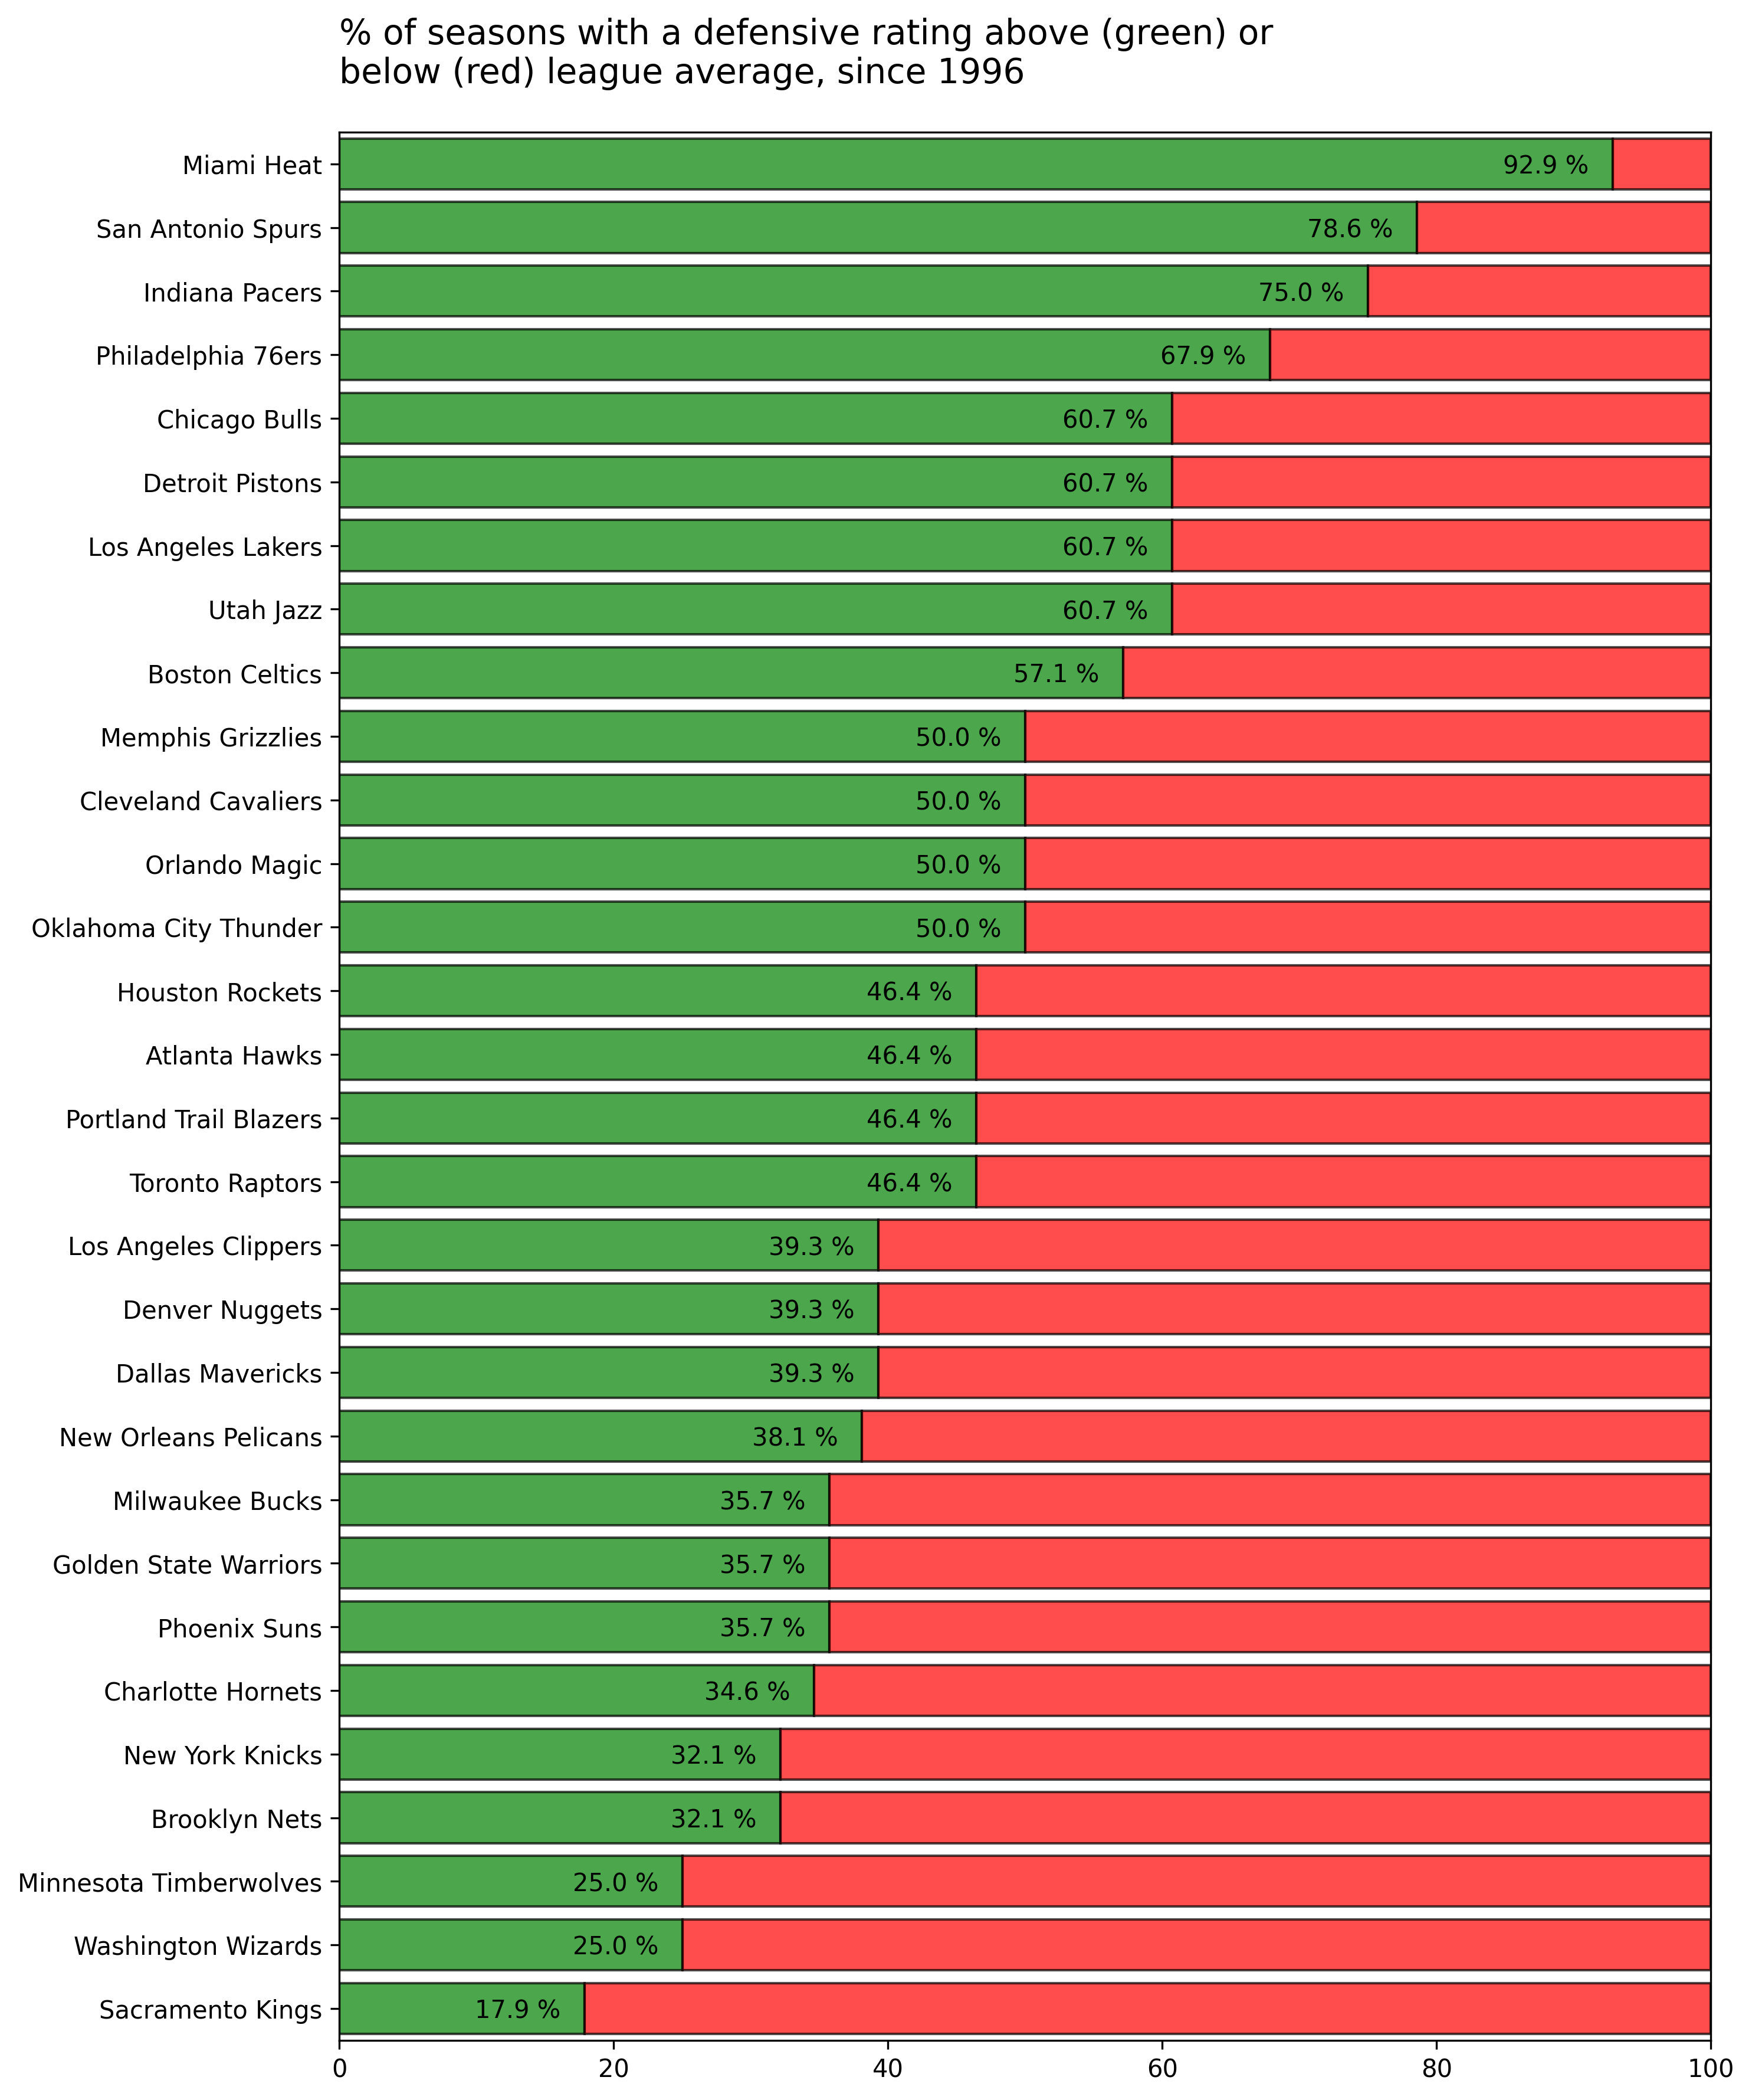

In [30]:
# Setting the figure size
figure, ax = plt.subplots(figsize=(10, 14), dpi=300)

# Plotting the % of seasons with above average defense
ax.barh(y=stack_df_def.Team, width=stack_df_def.n_aa, color='green',
        alpha=0.7, height=0.8, edgecolor='black')

# Annotating the bars
for i, v in enumerate(stack_df_def.n_aa):
    ax.text(v - 8, i - 0.15, str(round(v, 1)) + ' %', 
            color='black', fontsize=10)

# Plotting the % of seasons with a below average defense
ax.barh(y=stack_df_def.Team, width=stack_df_def.n_ba, color='red',
        left=stack_df_def.n_aa, alpha=0.7, height=0.8,
        edgecolor='black')

# Title
plt.title("% of seasons with a defensive rating above (green) or \nbelow (red) league average, since 1996",
          size=14, loc='left', pad=20)

# Axis limits
plt.xlim(0, 100)
plt.ylim(-0.5, 29.5)

In [31]:
# Years with an above average net rating
all_years_df['nrtg_above_avg'] = all_years_df['rel_NRtg'] > 0

# Number of years with an above average nrtg
plot_order_net = all_years_df.groupby('Team')['nrtg_above_avg'].sum().\
                 sort_values(ascending=False).index.tolist()

In [32]:
# FacetGrid for all teams
g = sns.FacetGrid(data=all_years_df, col='Team', col_wrap=5, height=5,
                  col_order=plot_order_net, sharex=False, xlim=(1996, 2023))

# Drawing the lineplots
g.map_dataframe(sns.lineplot, x='year', y=0)
g.map_dataframe(sns.lineplot, x='year', y='rel_NRtg')

# https://stackoverflow.com/questions/46248348/seaborn-matplotlib-how-to-access-line-values-in-facetgrid
# Filling between curves; red for a below average nrtg, green for an above
# average nrtg
for ax in g.axes.flat:
  x = ax.lines[0].get_xdata().astype(int)
  y1 = ax.lines[0].get_ydata(0)
  y2 = ax.lines[1].get_ydata()
  ax.fill_between(x, y1, y2, where=y2 > y1, facecolor='green', 
                  interpolate=True, alpha=0.4)
  ax.fill_between(x, y1, y2, where=y2 < y1, facecolor='red', 
                  interpolate=True, alpha=0.4)
  
# Adding the max NRtg
t, y, val = all_years_df.loc[all_years_df.rel_NRtg == all_years_df.rel_NRtg.max(),
                             ['Team', 'year', 'rel_NRtg']].values.flatten().tolist()
for ax in g.axes:
  ax.axhline(all_years_df.rel_NRtg.max(), ls='--')

annot_text = 'Best: '  + t + ', ' + str(y) + ': ' + str(round(val, 2)) + ' NRtg'
def annotate(**kwag):
    ax = plt.gca()
    ax.text(0.1, .9, annot_text,
            fontsize=12, fontweight='bold', transform=ax.transAxes)

g.map_dataframe(annotate)

# Setting xticks and xtick labels
xticks = [y for y in all_years_df.year.sort_values().unique().tolist()]
xticks = xticks[::2]
g.set(xticks=xticks)
g.set_xticklabels(labels=[str(y) for y in xticks], rotation=45)
g.fig.subplots_adjust(hspace=0.3)

# Setting y labels
g.set_ylabels('Relative Net Rating', fontsize=18)

# Individual titles for subplots
g.set_titles(template='{col_name}', size=18)

# Title
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Relative Net Rating (compared to league average) over the years',
               size=30)

# X label
g.set_xlabels('')
g.axes[-3].set_xlabel('Year', fontsize=25, labelpad=5)

plt.savefig('rel_def.png', dpi=300)